# Implemented Using MMSegmentation 
Welcome to Segmentation! 
 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# # Check nvcc version
# !nvcc -V
# # Check GCC version
# !gcc --version

In [ ]:
# # Install PyTorch
# !pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# # Install MMCV
# !pip install openmim
# !mim install mmcv-full

In [ ]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .

In [ ]:
# Or alternatively 
# pip install mmseg

In [ ]:
%pwd

In [ ]:
%cd mmsegmentation

In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1 True
0.28.0


## Run Inference with MMSeg trained weight

In [4]:
# !mkdir checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

In [5]:
# from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
# from mmseg.core.evaluation import get_palette

In [6]:
# config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
# checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [7]:
# # build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [8]:
# # test a single image
# img = 'demo/demo.png'
# result = inference_segmentor(model, img)

In [9]:
# # show the results
# show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [10]:
# # download and unzip
# !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
# !tar xf stanford_background.tar.gz

In [ ]:
# # Let's take a look at the dataset
# import mmcv
# import matplotlib.pyplot as plt

# img = mmcv.imread('iccv09Data/images/6000124.jpg')
# plt.figure(figsize=(8, 6))
# plt.imshow(mmcv.bgr2rgb(img))
# plt.show()

We need to convert the annotation into semantic map format as an image.

In [11]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'data/Goat_pixel_Sep_07_2022-14-20_Acme_Project'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
classes = ( 
    'sticker', 
    'background', 
    'Other', 
    'Tail', 
    'Body', 
    'Neck', 
    'Head' )

palette = [
    [63, 100, 24], 
    [133, 74, 39], 
    [214 ,84, 211], 
    [223 , 71, 154],        
    [120, 180, 248], 
    [51, 95, 247] , 
    [210, 69, 36]
    ]

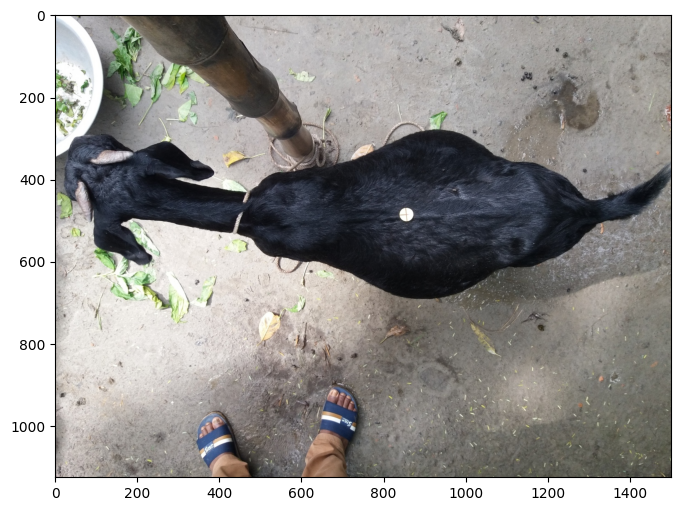

In [12]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread(f'{data_root}/{img_dir}/1_23_F_1.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

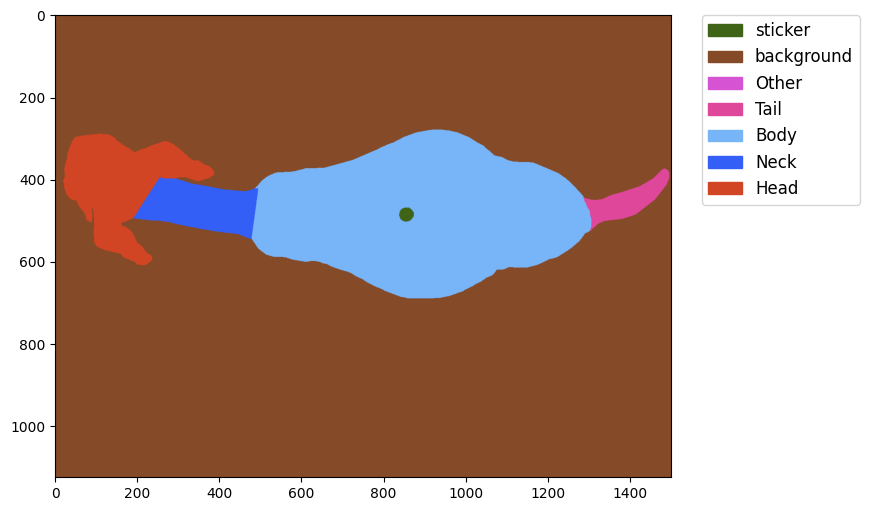

In [15]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
# img = Image.open('data/Goat_pixel_Sep_07_2022-14-20_Acme_Project/annotations/1_23_F_1.jpg___fuse.png')
img = Image.open(f'{data_root}/{ann_dir}/1_23_F_1.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [16]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [19]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class GoatSemanticSegmentation(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [20]:
# from mmcv import Config
# cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [21]:
# !mkdir checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_769x769_80k_cityscapes/deeplabv3plus_r50-d8_769x769_80k_cityscapes_20200606_210233-0e9dfdc4.pth -P checkpoints


In [22]:
# from mmcv import Config
# cfg = Config.fromfile('configs/deeplabv3plus/deeplabv3plus_r50-d8_769x769_80k_cityscapes.py')

In [23]:
from mmcv import Config
cfg = Config.fromfile('configs/deeplabv3plus/deeplabv3plus_r50-d8_512x1024_40k_cityscapes.py')

In [24]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,


Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [25]:
# from mmseg.apis import set_random_seed
# from mmseg.utils import get_device

# # Since we use only one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# # modify num classes of the model in decode/auxiliary head
# cfg.model.decode_head.num_classes = 8
# cfg.model.auxiliary_head.num_classes = 8

# # Modify dataset type and path
# cfg.dataset_type = 'StanfordBackgroundDataset'
# cfg.data_root = data_root

# cfg.data.samples_per_gpu = 8
# cfg.data.workers_per_gpu=8

# cfg.img_norm_cfg = dict(
#     mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# cfg.crop_size = (256, 256)
# cfg.train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations'),
#     dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
#     dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
#     dict(type='RandomFlip', flip_ratio=0.5),
#     dict(type='PhotoMetricDistortion'),
#     dict(type='Normalize', **cfg.img_norm_cfg),
#     dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_semantic_seg']),
# ]

# cfg.test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(320, 240),
#         # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(type='Normalize', **cfg.img_norm_cfg),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img']),
#         ])
# ]


# cfg.data.train.type = cfg.dataset_type
# cfg.data.train.data_root = cfg.data_root
# cfg.data.train.img_dir = img_dir
# cfg.data.train.ann_dir = ann_dir
# cfg.data.train.pipeline = cfg.train_pipeline
# cfg.data.train.split = 'splits/train.txt'

# cfg.data.val.type = cfg.dataset_type
# cfg.data.val.data_root = cfg.data_root
# cfg.data.val.img_dir = img_dir
# cfg.data.val.ann_dir = ann_dir
# cfg.data.val.pipeline = cfg.test_pipeline
# cfg.data.val.split = 'splits/val.txt'

# cfg.data.test.type = cfg.dataset_type
# cfg.data.test.data_root = cfg.data_root
# cfg.data.test.img_dir = img_dir
# cfg.data.test.ann_dir = ann_dir
# cfg.data.test.pipeline = cfg.test_pipeline
# cfg.data.test.split = 'splits/val.txt'

# # We can still use the pre-trained Mask RCNN model though we do not need to
# # use the mask branch
# # cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth'

# # Set up working dir to save files and logs.
# cfg.work_dir = './work_dirs/tutorial'

# cfg.runner.max_iters = 200
# cfg.log_config.interval = 10
# cfg.evaluation.interval = 200
# cfg.checkpoint_config.interval = 200

# # Set seed to facitate reproducing the result
# cfg.seed = 0
# set_random_seed(0, deterministic=False)
# cfg.gpu_ids = range(1)
# cfg.device = get_device()

# # Let's have a look at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

In [26]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 7
cfg.model.auxiliary_head.num_classes = 7

# Modify dataset type and path
cfg.dataset_type = 'GoatSemanticSegmentation'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu= 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (769, 769 )

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1500 , 1125 ), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]


cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500 , 1125),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


# # We divide it by 8 since we only use one GPU.
# cfg.optimizer.lr = 0.02 / 8

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth'

# Set up working dir to save files and logs.
# cfg.work_dir = './work_dirs/tutorial'
cfg.work_dir = './work_dirs/Goat_semantic'

cfg.runner.max_iters = 800
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=7,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_in

In [ ]:
# from mmseg.apis import set_random_seed
# from mmseg.utils import get_device

# # Since we use only one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# # modify num classes of the model in decode/auxiliary head
# cfg.model.decode_head.num_classes = 7
# cfg.model.auxiliary_head.num_classes = 7

# # Modify dataset type and path
# cfg.dataset_type = 'GoatSemanticSegmentation'
# cfg.data_root = data_root

# cfg.data.samples_per_gpu = 8
# cfg.data.workers_per_gpu=8

# cfg.img_norm_cfg = dict(
#     mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# cfg.crop_size = (256, 256)
# cfg.train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations'),
#     dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
#     dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
#     dict(type='RandomFlip', flip_ratio=0.5),
#     dict(type='PhotoMetricDistortion'),
#     dict(type='Normalize', **cfg.img_norm_cfg),
#     dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_semantic_seg']),
# ]

# cfg.test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(320, 240),
#         # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(type='Normalize', **cfg.img_norm_cfg),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img']),
#         ])
# ]


# cfg.data.train.type = cfg.dataset_type
# cfg.data.train.data_root = cfg.data_root
# cfg.data.train.img_dir = img_dir
# cfg.data.train.ann_dir = ann_dir
# cfg.data.train.pipeline = cfg.train_pipeline
# cfg.data.train.split = 'splits/train.txt'

# cfg.data.val.type = cfg.dataset_type
# cfg.data.val.data_root = cfg.data_root
# cfg.data.val.img_dir = img_dir
# cfg.data.val.ann_dir = ann_dir
# cfg.data.val.pipeline = cfg.test_pipeline
# cfg.data.val.split = 'splits/val.txt'

# cfg.data.test.type = cfg.dataset_type
# cfg.data.test.data_root = cfg.data_root
# cfg.data.test.img_dir = img_dir
# cfg.data.test.ann_dir = ann_dir
# cfg.data.test.pipeline = cfg.test_pipeline
# cfg.data.test.split = 'splits/val.txt'

# # We can still use the pre-trained Mask RCNN model though we do not need to
# # use the mask branch
# # cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth'

# # Set up working dir to save files and logs.
# cfg.work_dir = './work_dirs/Goat_semantic'

# cfg.runner.max_iters = 200
# cfg.log_config.interval = 10
# cfg.evaluation.interval = 200
# cfg.checkpoint_config.interval = 200

# # Set seed to facitate reproducing the result
# cfg.seed = 0
# set_random_seed(0, deterministic=False)
# cfg.gpu_ids = range(1)
# cfg.device = get_device()

# # Let's have a look at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

### Train and Evaluation

In [27]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-09-28 07:29:10,786 - mmseg - INFO - Loaded 390 images
/mnt/d/Personal/project_temp/openmmlab/mmsegmentation/demo/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/mnt/d/Personal/project_temp/openmmlab/mmsegmentation/demo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2022-09-28 07:29:14,716 - mmseg - INFO - Loaded 98 images
2022-09-28 07:29:14,720 - mmseg - INFO - load checkpoint from local path: checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth
2022-09-28 07:29:15,168 - mmseg - WARNING - The model and loaded state dict do not match exact

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 98/98, 0.4 task/s, elapsed: 278s, ETA:     0s

2022-09-28 07:37:17,254 - mmseg - INFO - per class results:
2022-09-28 07:37:17,257 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|  sticker   |  36.9 | 76.35 |
| background |  0.0  |  0.0  |
|   Other    |  0.0  |  0.0  |
|    Tail    | 15.61 | 22.46 |
|    Body    | 41.35 | 63.94 |
|    Neck    |  0.0  |  0.0  |
|    Head    |  0.0  |  0.0  |
+------------+-------+-------+
2022-09-28 07:37:17,258 - mmseg - INFO - Summary:
2022-09-28 07:37:17,260 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 46.82 | 13.41 | 23.25 |
+-------+-------+-------+
2022-09-28 07:37:17,262 - mmseg - INFO - Iter(val) [98]	aAcc: 0.4682, mIoU: 0.1341, mAcc: 0.2325, IoU.sticker: 0.3690, IoU.background: 0.0000, IoU.Other: 0.0000, IoU.Tail: 0.1561, IoU.Body: 0.4135, IoU.Neck: 0.0000, IoU.Head: 0.0000, Acc.sticker: 0.7635, Acc.background: 0.0000, Acc.Other: 0.0000, Acc.Tail: 0.2246, Acc.Body: 0.6394, A

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 98/98, 0.4 task/s, elapsed: 273s, ETA:     0s

2022-09-28 07:44:54,116 - mmseg - INFO - per class results:
2022-09-28 07:44:54,119 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|  sticker   | 32.52 |  94.5 |
| background |  0.0  |  0.0  |
|   Other    |  0.0  |  0.0  |
|    Tail    | 36.72 | 78.16 |
|    Body    |  1.56 |  1.57 |
|    Neck    |  8.15 | 10.86 |
|    Head    |  0.0  |  0.0  |
+------------+-------+-------+
2022-09-28 07:44:54,120 - mmseg - INFO - Summary:
2022-09-28 07:44:54,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 38.86 | 11.28 | 26.44 |
+-------+-------+-------+
2022-09-28 07:44:54,124 - mmseg - INFO - Iter(val) [98]	aAcc: 0.3886, mIoU: 0.1128, mAcc: 0.2644, IoU.sticker: 0.3252, IoU.background: 0.0000, IoU.Other: 0.0000, IoU.Tail: 0.3672, IoU.Body: 0.0156, IoU.Neck: 0.0815, IoU.Head: 0.0000, Acc.sticker: 0.9450, Acc.background: 0.0000, Acc.Other: 0.0000, Acc.Tail: 0.7816, Acc.Body: 0.0157, A

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 98/98, 0.4 task/s, elapsed: 268s, ETA:     0s

2022-09-28 07:52:22,196 - mmseg - INFO - per class results:
2022-09-28 07:52:22,198 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|  sticker   | 62.07 |  92.4 |
| background |  6.16 |  7.0  |
|   Other    |  0.0  |  0.0  |
|    Tail    | 39.54 | 93.09 |
|    Body    |  0.0  |  0.0  |
|    Neck    | 26.53 | 54.15 |
|    Head    |  0.0  |  0.0  |
+------------+-------+-------+
2022-09-28 07:52:22,199 - mmseg - INFO - Summary:
2022-09-28 07:52:22,201 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 44.09 | 19.19 | 35.23 |
+-------+-------+-------+
2022-09-28 07:52:22,202 - mmseg - INFO - Iter(val) [98]	aAcc: 0.4409, mIoU: 0.1919, mAcc: 0.3523, IoU.sticker: 0.6207, IoU.background: 0.0616, IoU.Other: 0.0000, IoU.Tail: 0.3954, IoU.Body: 0.0000, IoU.Neck: 0.2653, IoU.Head: 0.0000, Acc.sticker: 0.9240, Acc.background: 0.0700, Acc.Other: 0.0000, Acc.Tail: 0.9309, Acc.Body: 0.0000, A

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 98/98, 0.4 task/s, elapsed: 271s, ETA:     0s

2022-09-28 07:59:52,635 - mmseg - INFO - per class results:
2022-09-28 07:59:52,637 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|  sticker   |  61.1 | 97.51 |
| background |  0.0  |  0.0  |
|   Other    |  0.0  |  0.0  |
|    Tail    | 16.87 | 21.39 |
|    Body    | 49.74 | 76.95 |
|    Neck    | 26.56 | 56.02 |
|    Head    |  0.0  |  0.0  |
+------------+-------+-------+
2022-09-28 07:59:52,638 - mmseg - INFO - Summary:
2022-09-28 07:59:52,640 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 55.85 | 22.04 | 35.98 |
+-------+-------+-------+
2022-09-28 07:59:52,641 - mmseg - INFO - Iter(val) [98]	aAcc: 0.5585, mIoU: 0.2204, mAcc: 0.3598, IoU.sticker: 0.6110, IoU.background: 0.0000, IoU.Other: 0.0000, IoU.Tail: 0.1687, IoU.Body: 0.4974, IoU.Neck: 0.2656, IoU.Head: 0.0000, Acc.sticker: 0.9751, Acc.background: 0.0000, Acc.Other: 0.0000, Acc.Tail: 0.2139, Acc.Body: 0.7695, A

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [28]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./work_dirs/Goat_semantic
# cfg.work_dir = './motorcycle_marker/mask_rcnn_r50_caffe_fpn_mstrain-poly_2x_coco'

Inference with trained model

/mnt/d/Personal/project_temp/openmmlab/mmsegmentation/demo/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 800x600 with 0 Axes>

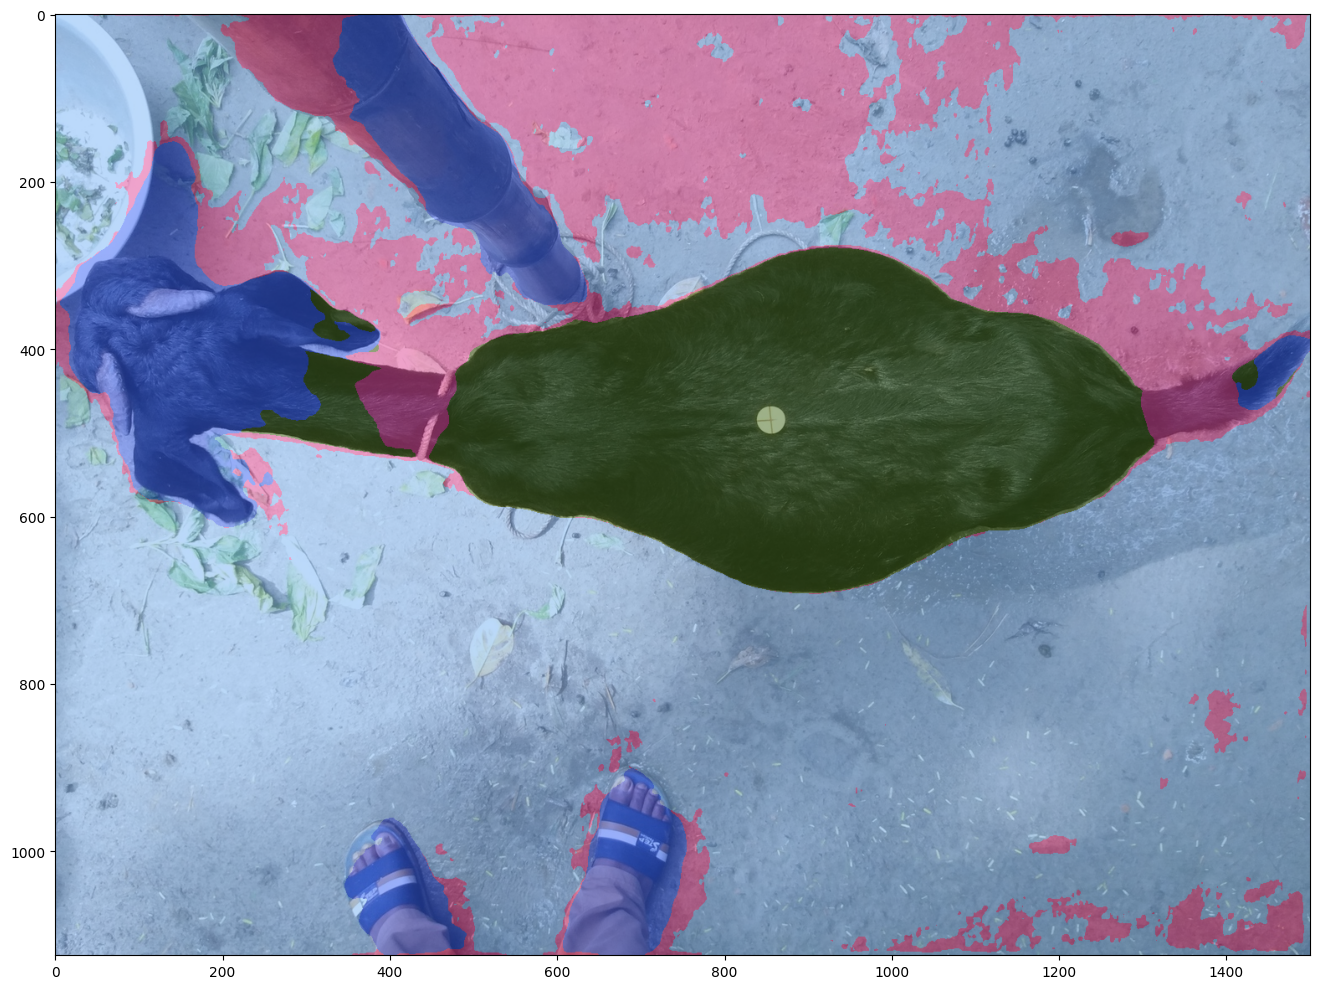

In [29]:
from mmseg.apis import inference_segmentor, show_result_pyplot
# img = mmcv.imread('iccv09Data/images/6000124.jpg')
img = mmcv.imread(f'{data_root}/{img_dir}/1_23_F_1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)